# Visualization of COVID-19 infection and death rates using plotly

In [305]:
# load python packages
import plotly
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import time
from datetime import datetime, timedelta
from palettable.colorbrewer.qualitative import Pastel1_7, Dark2_6, Paired_12
from palettable.colorbrewer.diverging import Spectral_11

In [320]:
import chart_studio.plotly as py
import chart_studio
from plotly_credentials import USERNAME, API_KEY

In [3]:
# read-in data https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')

In [4]:
# check what is in the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8102 entries, 0 to 8101
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  8102 non-null   object 
 1   day                      8102 non-null   int64  
 2   month                    8102 non-null   int64  
 3   year                     8102 non-null   int64  
 4   cases                    8102 non-null   int64  
 5   deaths                   8102 non-null   int64  
 6   countriesAndTerritories  8102 non-null   object 
 7   geoId                    8084 non-null   object 
 8   countryterritoryCode     8031 non-null   object 
 9   popData2018              8084 non-null   float64
dtypes: float64(1), int64(5), object(4)
memory usage: 633.1+ KB


In [5]:
# eyeball the data
data
# dates go latest to earliest, need to reverse, they also need o be made date time objects so we can order them properly

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,01/04/2020,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0
1,31/03/2020,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
2,30/03/2020,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0
3,29/03/2020,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
4,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...,...
8097,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
8098,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
8099,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
8100,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0


In [48]:
# change to datetime and sort as dates are in reverse order
data['dateRep'] = pd.to_datetime(data['dateRep'], dayfirst=True)
data.sort_values(by=['countriesAndTerritories','dateRep'], ascending = True, inplace = True)
data = data.reindex()

In [49]:
data

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,total_cases,total_deaths,total_cases_7day,total_deaths_7day
82,2019-12-31,31,12,2019,0,0,Afghanistan,AF,AFG,37172386.0,0,0,0.0,0.0
81,2020-01-01,1,1,2020,0,0,Afghanistan,AF,AFG,37172386.0,0,0,121.0,8.0
80,2020-01-02,2,1,2020,0,0,Afghanistan,AF,AFG,37172386.0,0,0,1.0,0.0
79,2020-01-03,3,1,2020,0,0,Afghanistan,AF,AFG,37172386.0,0,0,48.0,2.0
78,2020-01-04,4,1,2020,0,0,Afghanistan,AF,AFG,37172386.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8094,2020-03-28,28,3,2020,2,0,Zimbabwe,ZW,ZWE,14439018.0,5,1,2368.0,17.0
8093,2020-03-29,29,3,2020,2,0,Zimbabwe,ZW,ZWE,14439018.0,7,1,646.0,5.0
8092,2020-03-30,30,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,7,1,1.0,0.0
8091,2020-03-31,31,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,7,1,0.0,0.0


In [53]:
#create cumulative sum of deaths and cases
data['total_cases'] = data.groupby(by='countriesAndTerritories')['cases'].cumsum()
data['total_deaths'] = data.groupby(by='countriesAndTerritories')['deaths'].cumsum()

# also create 7 day rolling average
data['total_cases_7day'] = data.groupby(by='countriesAndTerritories')['cases'].rolling(7,min_periods=1).sum().values
data['total_deaths_7day'] = data.groupby(by='countriesAndTerritories')['deaths'].rolling(7,min_periods=1).sum().values

In [ ]:
# useful functions
def make_chart_data(country):
    ''' makes a seperate dataset for a country
        takes country name as input '''
    chart_data = data.loc[data['countriesAndTerritories'] == country].reset_index()
    return chart_data

def reindex(df, var, min_cases_per_week = 10):
    ''' creates a data series which shifts data so that the day 
    where the criteria min_cases_per_week is reached is at index 0'''
    dta = df.copy()
    try:
        if var == 'total_cases':
            first_day = dta[dta['total_cases_7day']>min_cases_per_week].index[0]
        elif var == 'total_deaths':
            first_day = dta[dta['total_deaths_7day']>min_cases_per_week].index[0]
        else:
            pass
        dta[var] = dta[var].shift(-first_day)
    except:
        dta[var] = np.nan
    return dta 


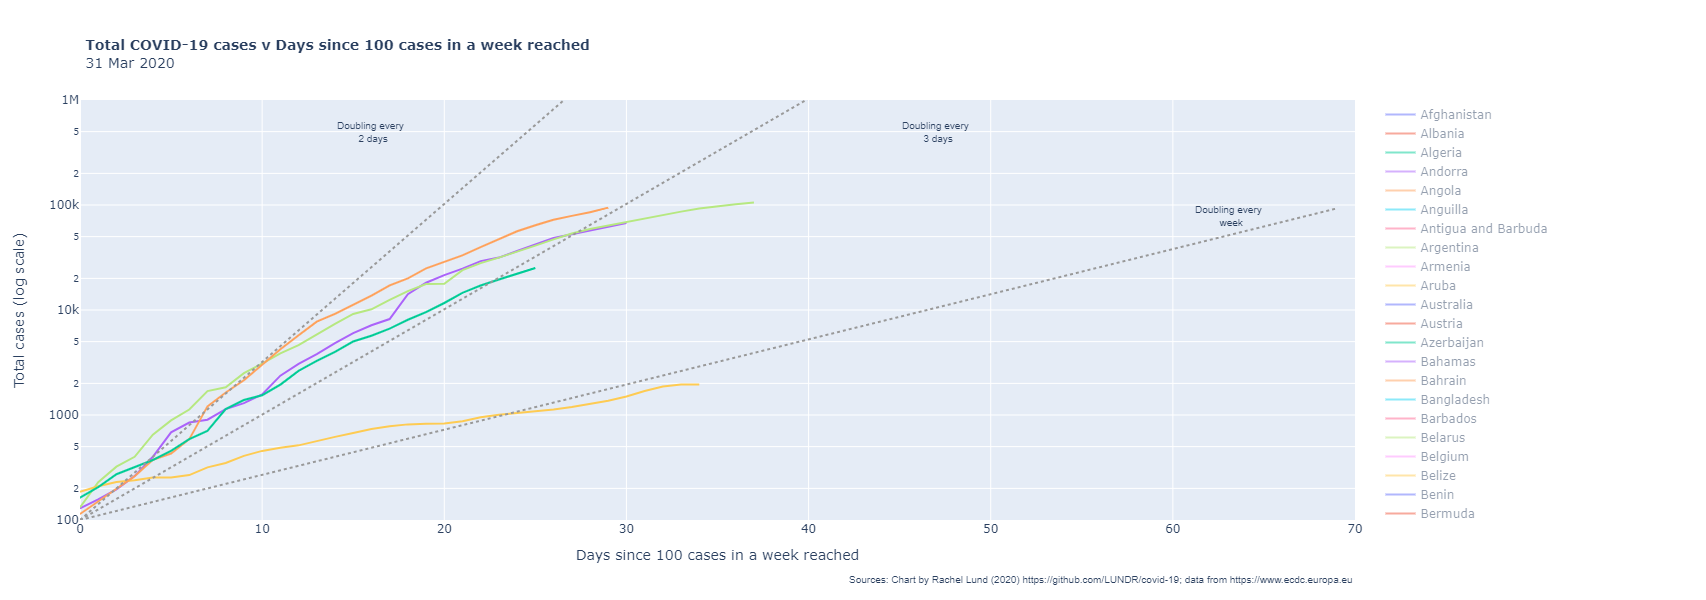

In [345]:

countries = data['countriesAndTerritories'].unique()
colours = Paired_12.hex_colors

dfs = dict()
traces = dict()
var = 'total_cases'
plots = []
annotations = []
min_cases_per_week = 100
default_list = ['Germany','Japan','United_Kingdom','Italy','Spain']

# calculate the latest data included: NB there is a lag of a day so we need to subtract a day from the latest data reported.
latest_data = data['dateRep'].max()- timedelta(days=1)
latest_data_string = latest_data.strftime("%d %b %Y")


for i in countries:
    try:
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i,var),var,min_cases_per_week)
            traces[i] = go.Scatter(x=dfs[i].index, y=dfs[i][var], mode = 'lines', line = dict(shape ='hv'),marker = dict(), line_shape = 'linear', name = ' '.join(i.split('_')), text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], hovertemplate = "<br><b>%{text}</b><br><i>Cases</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i,var),var,min_cases_per_week)
            traces[i] = go.Scatter(x=dfs[i].index, y=dfs[i][var], mode = 'lines', line = dict(shape ='hv'),marker = dict(), line_shape = 'linear',name = ' '.join(i.split('_')), visible = 'legendonly', text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], hovertemplate = "<br><b>%{text}</b><br><i>Cases</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
            
    except:
        pass
    
three_days = go.Scatter(x=np.array(range(0,70)), y=min_cases_per_week*(2**(1/3))**np.array(range(0,70)), mode = 'lines', line = dict(color='#999999', shape ='hv', dash='dot'), line_shape = 'linear', name = 'Doubling every three days',hoverinfo='skip')
two_days = go.Scatter(x=np.array(range(0,70)), y=min_cases_per_week*(2**(1/2))**np.array(range(0,70)), mode = 'lines', line = dict(color='#999999', shape ='hv', dash='dot'), line_shape = 'linear', name = 'Doubling every two days',hoverinfo='skip')
seven_days = go.Scatter(x=np.array(range(0,70)), y=min_cases_per_week*(2**(1/7))**np.array(range(0,70)), mode = 'lines', line = dict(color='#999999', shape ='hv', dash='dot'), line_shape = 'linear', name = 'Doubling every week',hoverinfo='skip')

plots.append(three_days)
plots.append(two_days)
plots.append(seven_days)

annotations.append(dict(xref='paper', x=0.2, y=5.7,text='Doubling every <BR> 2 days',font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper', x=0.7, y=5.7,text='Doubling every <BR> 3 days',font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper', x=0.93, y=4.9,text='Doubling every <BR> week',font=dict(family='Arial',size=10),showarrow=False))

footnote = dict(xref='paper', xanchor='right', x=1, yanchor='top',y=2,text='<BR> <BR> <BR> <BR> <BR>Sources: Chart by Rachel Lund (2020) https://github.com/LUNDR/covid-19; data from https://www.ecdc.europa.eu',font=dict(family='Arial',size=10),showarrow=False)
annotations.append(footnote)

fig = go.Figure(plots)
fig.update_layout(yaxis_type="log", height = 600, width = 900, title="<b>Total COVID-19 cases v Days since "+str(min_cases_per_week)+" "+ var.split('_')[1]+" in a week reached </b> <BR>"+latest_data_string, annotations = annotations,titlefont ={
    "size": 14
  })
fig.layout.xaxis.update(title='Days since '+ str(min_cases_per_week)+' '+ var.split('_')[1] +' in a week reached', range=[0, 70])
fig.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()+' (log scale)'), range=[2, 6])
fig.show()
    

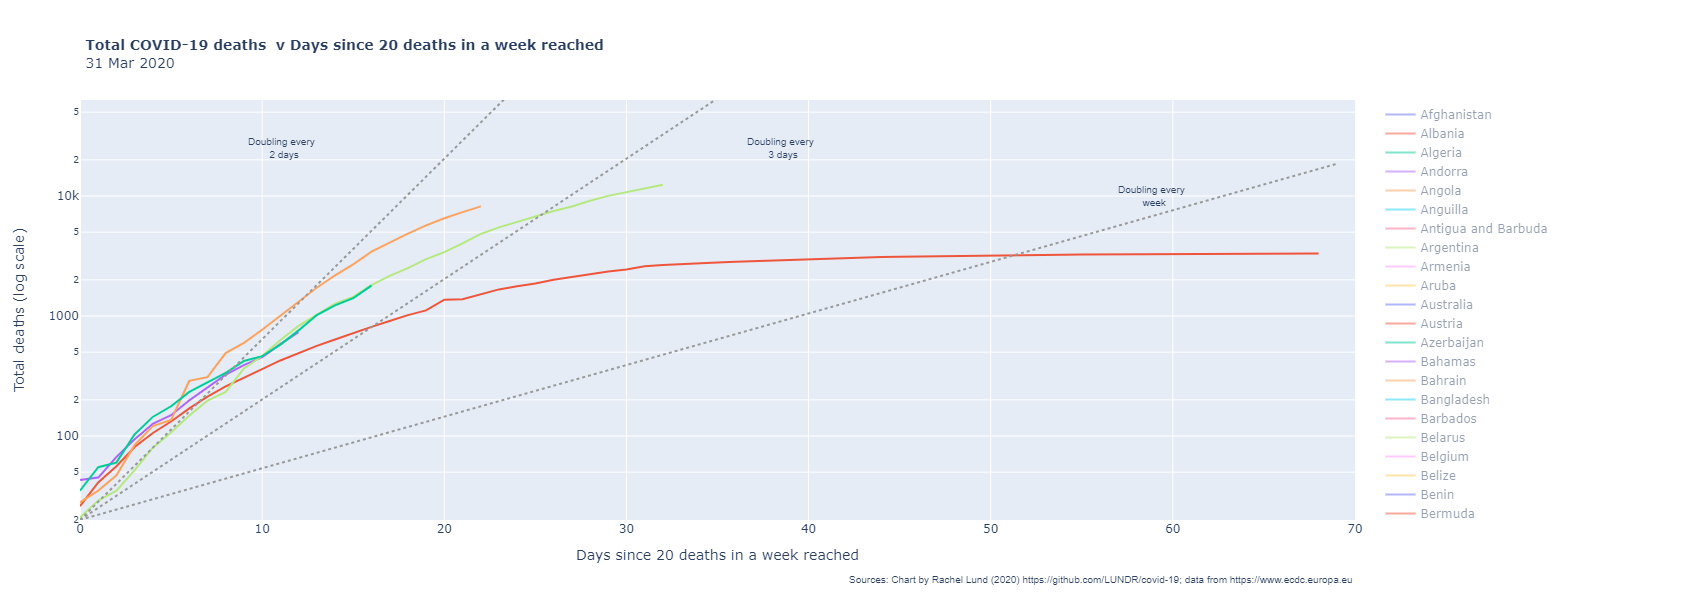

In [349]:

countries = data['countriesAndTerritories'].unique()
colours = Paired_12.hex_colors

dfs = dict()
traces = dict()
var = 'total_deaths'
plots = []
annotations = []
min_cases_per_week = 20
default_list = ['Germany','Japan','United_Kingdom','Italy','Spain', 'China']

# calculate the latest data included: NB there is a lag of a day so we need to subtract a day from the latest data reported.
latest_data = data['dateRep'].max()- timedelta(days=1)
latest_data_string = latest_data.strftime("%d %b %Y")


for i in countries:
    try:
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i,var),var,min_cases_per_week)
            traces[i] = go.Scatter(x=dfs[i].index, y=dfs[i][var], mode = 'lines', line = dict(shape ='hv'),marker = dict(), line_shape = 'linear', name = ' '.join(i.split('_')), text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], hovertemplate = "<br><b>%{text}</b><br><i>Deaths</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i,var),var,min_cases_per_week)
            traces[i] = go.Scatter(x=dfs[i].index, y=dfs[i][var], mode = 'lines', line = dict(shape ='hv'),marker = dict(), line_shape = 'linear',name = ' '.join(i.split('_')), visible = 'legendonly', text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], hovertemplate = "<br><b>%{text}</b><br><i>Deaths</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
            
    except:
        pass
    
three_days = go.Scatter(x=np.array(range(0,70)), y=min_cases_per_week*(2**(1/3))**np.array(range(0,70)), mode = 'lines', line = dict(color='#999999', shape ='hv', dash='dot'), line_shape = 'linear', name = 'Doubling every three days',hoverinfo='skip')
two_days = go.Scatter(x=np.array(range(0,70)), y=min_cases_per_week*(2**(1/2))**np.array(range(0,70)), mode = 'lines', line = dict(color='#999999', shape ='hv', dash='dot'), line_shape = 'linear', name = 'Doubling every two days',hoverinfo='skip')
seven_days = go.Scatter(x=np.array(range(0,70)), y=min_cases_per_week*(2**(1/7))**np.array(range(0,70)), mode = 'lines', line = dict(color='#999999', shape ='hv', dash='dot'), line_shape = 'linear', name = 'Doubling every week',hoverinfo='skip')

plots.append(three_days)
plots.append(two_days)
plots.append(seven_days)

annotations.append(dict(xref='paper', x=0.13, y=4.4,text='Doubling every <BR> 2 days',font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper', x=0.55, y=4.4,text='Doubling every <BR> 3 days',font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper', x=0.87, y=4,text='Doubling every <BR> week',font=dict(family='Arial',size=10),showarrow=False))

footnote = dict(xref='paper', xanchor='right', x=1, yanchor='top',y=1.3,text='<BR> <BR> <BR> <BR> <BR>Sources: Chart by Rachel Lund (2020) https://github.com/LUNDR/covid-19; data from https://www.ecdc.europa.eu',font=dict(family='Arial',size=10),showarrow=False)
annotations.append(footnote)

fig2 = go.Figure(plots)
fig2.update_layout(yaxis_type="log", height = 600, width = 900, title="<b>Total COVID-19 deaths  v Days since "+str(min_cases_per_week)+" "+ var.split('_')[1]+" in a week reached </b> <BR>"+latest_data_string, annotations = annotations,titlefont ={
    "size": 14
  })
fig2.layout.xaxis.update(title='Days since '+ str(min_cases_per_week)+' '+ var.split('_')[1] +' in a week reached', range=[0, 70])
fig2.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()+' (log scale)'), range=[1.3, 4.8])
fig2.show()
    

In [350]:
chart_studio.tools.set_credentials_file(username=USERNAME, api_key=API_KEY)
py.plot(fig, filename='covid-19 cases', sharing='public')
py.plot(fig2, filename='covid-19 deaths', sharing='public')

'https://plotly.com/~RLUND/46/'

1.3492828476735634